In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten
from keras.layers import BatchNormalization ,Concatenate
from keras.layers import Reshape,Embedding ,Activation ,UpSampling2D, multiply
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

In [2]:
x_train = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/x_train_gray.npy')
x_test = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/x_test_gray.npy')
y_train = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/y_train.npy')
y_test = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/y_test.npy')

def one_hot( y, c):
    Ty = np.zeros((max(y.shape), c),dtype=int)
    for i in range(c):
        Ty[y.reshape(max(y.shape)) == i, i] = 1
    return Ty
label_train = y_train
label_test = y_test
# y_train = one_hot(y_train,2)
# y_test = one_hot(y_test,2)

size_image = x_train.shape[1]
print(y_train.shape,y_test.shape)


(1999,) (482,)


In [ ]:
def get_discriminator(input_shape=(128,128,1),n_class=2):
  
  model = Sequential()
  model.add(Conv2D(32, (3,3), strides=2, padding='same', input_shape=input_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  
  model.add(Conv2D(64,(3,3), strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  
  model.add(Conv2D(128, (3,3), strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  
  model.add(Conv2D(256, (3,3), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  
  model.add(Flatten())
  
  #model.summary()
		
  input_image = Input(shape=input_shape)

  #Extrating features from the model
  features = model(input_image)
  
  # AC GAN has 2 outputs, 1 for real or Fake using sigmoid activation. Another for class prediction using softmax.

  validity_output = Dense(1, activation='sigmoid')(features)
  label_output = Dense(n_class, activation='softmax')(features)

  model = Model(input_image,[validity_output,label_output])

  model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5))

  return model

In [ ]:
model = get_discriminator()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 65536)        387840      input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            65537       sequential[0][0]                 
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            131074      sequential[0][0]                 
Total params: 584,451
Trainable params: 584,451
Non-trainable params: 0
______________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
def get_generator(latent_dim,n_class=2):

		model = Sequential()
		model.add(Dense(32*32*256, input_dim=latent_dim))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Reshape((32,32,256)))
		model.add(Dropout(0.4))
		
		model.add(Conv2DTranspose(128,(5,5),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(64,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(32,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Conv2DTranspose(1,(3,3),padding='same'))
		model.add(Activation('sigmoid'))
		
		noise = Input(shape=(latent_dim,))
		label = Input(shape = (1,), dtype='int32')
		
		label_embeddings = Flatten()(Embedding(n_class,latent_dim)(label))  # Embedding --> for each elemnt in latent , predicted label(0 or 1)
		
		
		model_input = multiply([noise,label_embeddings])  # combined image noisy and label predict
		
		generated_image = model(model_input)
		
		#model.summary()
		
		return Model([noise,label],generated_image)




In [ ]:
latent = 100
model = get_generator(latent_dim=latent)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       200         input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding[0][0]                  
____________________________________________________________________________________________

In [ ]:
def combine(g_model,d_model,latent_dim):
  random_input = Input(shape=(latent_dim,))
  label = Input(shape=(1,))

  generate_image = g_model([random_input,label])

  d_model.trainable = False
  validity , label_out = d_model(generate_image)

  combined_model = Model([random_input,label],[validity,label_out])
  combined_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002,beta_1=0.5),metrics=['accuracy'])

  return combined_model



In [ ]:
def display_image(g_model,n_class,latent_dim,n_sample=100):
  row , col = 3,3
  x_input = np.random.randn(latent_dim*n_sample)
  noise = x_input.reshape(n_sample,latent_dim)

  gen_label = np.random.randint(0,n_class,n_sample)

  gen_image = g_model.predict([noise,gen_label])

  for i in range(row*col):
    plt.subplot(row,col,1+i)
    plt.axis('off')
    plt.imshow(gen_image[i,:,:,0],cmap='gray')
    if gen_label[i] == 0 :
      plt.title(f'label:Non-Covid')
    elif gen_label[i] == 1:
      plt.title(f'label:Covid')
  plt.show()

  return gen_image,gen_label


In [ ]:
def train_acgan(x_train,y_train,epochs=10000,batch_size=32,save_freq=200):

  x_train = np.expand_dims(x_train, axis=-1)
  y_train = y_train.reshape(-1,1)

  latent_dim=100
  n_class=2

  g_model = get_generator(latent_dim)
  d_model = get_discriminator()
  combined_model = combine(g_model, d_model, latent_dim)

  count = 1

  generate_x = []
  generate_y = []
  
  for epoch in range(epochs):
    noise = np.random.normal(0,1,size=[batch_size,latent_dim])
    idx = np.random.randint(0,x_train.shape[0],size=batch_size)

    x_real , y_real = x_train[idx] , y_train[idx]

    y_fake = np.random.randint(0,n_class,(batch_size,1))
    x_fake = g_model.predict([noise,y_fake])

    x = np.concatenate((x_real,x_fake))
    y = np.concatenate((y_real,y_fake))

    y_real_or_fake = np.ones([2*batch_size,1])    # putting all image as real
    y_real_or_fake[batch_size:, : ] = 0           # putting 0 for fake image

    y_onehot = to_categorical(y,num_classes=n_class)
    
    d_eval = d_model.train_on_batch(x,[y_real_or_fake,y_onehot])

    y_real_or_fake = np.ones([batch_size,1])

    noise = np.random.normal(0,1,size=[batch_size,latent_dim])
    sample_y= np.random.randint(0,n_class,batch_size).reshape(-1,1)
    encoded_sample_y = to_categorical(sample_y,n_class)
    g_eval = combined_model.train_on_batch([noise,sample_y], [y_real_or_fake,encoded_sample_y])

    if save_freq>0:
      if epoch % save_freq == 0:
        print ("epoch %d: [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_eval[0], 100*d_eval[1], g_eval[0], 100*g_eval[1]))
        x_out , y_out = display_image(g_model,n_class,latent_dim)
        count +=1
        generate_x.append(x_out)
        generate_y.append(y_out)
 

  generate_x = np.array(generate_x)
  generate_y = np.array(generate_y)
  print(generate_x.shape)
  print(generate_y.shape)

  # np.save('/content/drive/MyDrive/Deep ConvNet/HW4/generate_x3.npy',generate_x)
  # np.save('/content/drive/MyDrive/Deep ConvNet/HW4/generate_y3.npy',generate_y)


train_acgan(x_train,y_train)

Output hidden; open in https://colab.research.google.com to view.

In [3]:
pip install plot-metric

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score , roc_curve
from plot_metric.functions import BinaryClassification

In [21]:
# plot ROC curve
def plot_roc(true_label,pred_label):
  fpr, tpr, _ = roc_curve(true_label,  pred_label)
  auc = roc_auc_score(true_label, pred_label)
  plt.plot(fpr,tpr,label="ROC curve, AUC="+str(auc))
  plt.legend(loc=4)
  plt.show()

In [6]:
def bin_roc(true_label,pred_label):
  bc = BinaryClassification(true_label, pred_label, labels=["Covid", "None-covid"])
  # Figures
  plt.figure(figsize=(5,5))
  bc.plot_roc_curve()
  plt.show()

In [7]:
def plot_acc_loss(history):

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [28]:
#  Deep ConvNet --> VGG16

def convNet(x_test,y_test):
  vgg_model = VGG16(weights=None,include_top=False,input_shape=(128,128,1))

  x = vgg_model.layers[-1].output

  x = layers.MaxPool2D()(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1024,activation='relu')(x)
  x = layers.Dropout(0.4)(x)
  x = layers.Dense(10,activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  output = layers.Dense(2,activation='softmax')(x)

  model = tf.keras.models.Model(vgg_model.input,output)
  model.summary()

  model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])

  history = model.fit(x_train,y_train,epochs=100,batch_size=64,validation_split=0.2)
                      
  # resualt = model.evaluate(x_test,y_test)[1]
  plot_acc_loss(history)

  pred = model.predict(x_test)
  probability = np.max(pred,axis=1)
  pred = np.argmax(pred,axis=1)


  accuracy = accuracy_score(y_test,pred)
  print('Accuracy:',accuracy)

  precision = precision_score(y_test,pred,average='binary')
  print('Precision:',precision)

  recall = recall_score(y_test,pred,average='binary')
  print('Recall:',recall)

  f_score = f1_score(y_test,pred,average='binary')
  print('F-Measure:',f_score)

  auc = roc_auc_score(y_test, pred)
  print('AUC:',auc)

  plot_roc(y_test,probability)
  bin_roc(y_test,probability)


In [9]:
def one_hot( y, c):
    Ty = np.zeros((max(y.shape), c),dtype=int)
    for i in range(c):
        Ty[y.reshape(max(y.shape)) == i, i] = 1
    return Ty

y_train = one_hot(y_train,2)
y_test = one_hot(y_test,2)

(5000, 128, 128)
(5000,)
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None

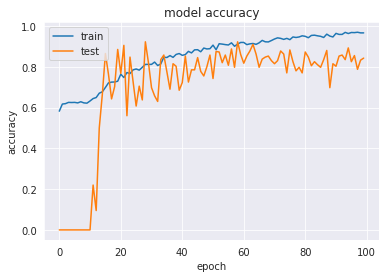

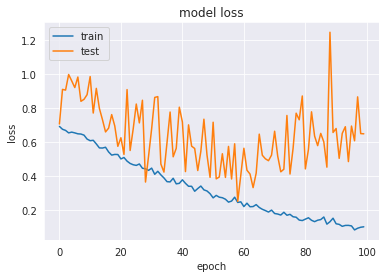

Accuracy: 0.934
Precision: 0.9073226544622426
Recall: 0.9647201946472019
F-Measure: 0.9351415094339623
AUC: 0.934412188878455


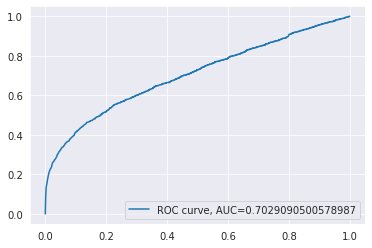

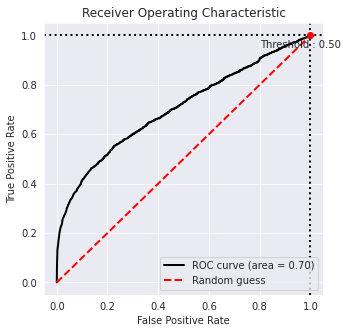

In [29]:
# load generate images with AC-GAN and consider the test data for predict in ConvNet

gen_x = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/generate_x3.npy')
gen_y = np.load('/content/drive/MyDrive/Deep ConvNet/HW4/generate_y3.npy')

gen_test_x = []
gen_test_y = []
for i in range(gen_x.shape[0]):
  for j in range(gen_x.shape[1]):
    gen_test_x.append(gen_x[i,j,:,:,0])
    gen_test_y.append(gen_y[i,j])

gen_test_x = np.array(gen_test_x)
gen_test_y = np.array(gen_test_y)

print(gen_test_x.shape)
print(gen_test_y.shape)

convNet(gen_test_x,gen_test_y)
    

(5096,)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)   

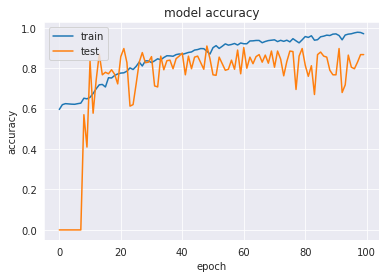

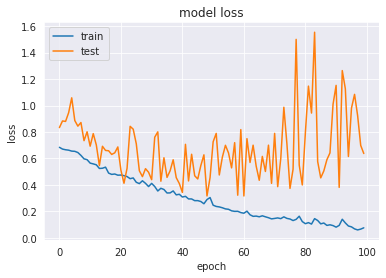

Accuracy: 0.9452511773940345
Precision: 0.9500604107933951
Recall: 0.9383452665075577
F-Measure: 0.94416649989994
AUC: 0.9451602397603629


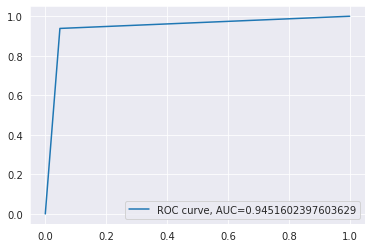

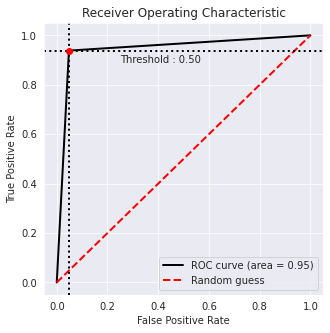

In [ ]:
# combine 20% original test image and all the generate image with AC-GAN

test_20 = int(x_test.shape[0] * 0.2)
org_test = np.random.randint(0,x_test.shape[0],test_20)
new_test_x = []
new_test_y = []
for i in range(test_20):
  new_test_x.append(x_test[org_test[i]])
  new_test_y.append(label_test[org_test[i]])
new_test_x = np.array(new_test_x)
new_test_y = np.array(new_test_y)

test_data = np.concatenate((gen_test_x,new_test_x),axis=0)
test_label = np.concatenate((gen_test_y,new_test_y),axis=0)
print(test_label.shape)
convNet(test_data,test_label)

(5482, 128, 128)
(5482,)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None

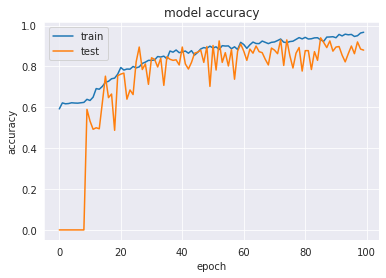

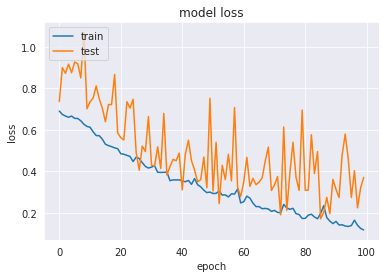

Accuracy: 0.9270339292229114
Precision: 0.9211482558139535
Recall: 0.9326710816777042
F-Measure: 0.926873857404022
AUC: 0.9270808375103426


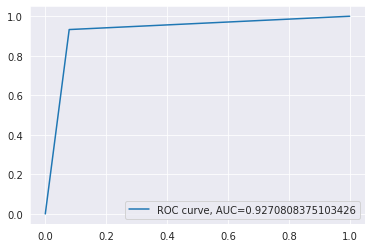

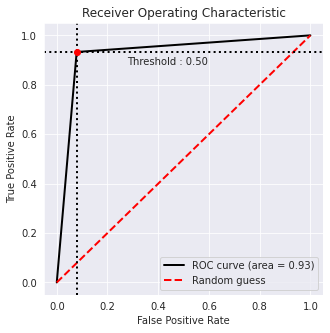

In [ ]:
# combine all original test images and all generate images

all_test_data = np.concatenate((x_test,gen_test_x),axis=0)
all_test_label = np.concatenate((label_test,gen_test_y),axis=0)
print(all_test_data.shape)
print(all_test_label.shape)

convNet(all_test_data,all_test_label)